This notebook contains a bit of exploratory analysis of the ionosphere dataset.

Let's first load a couple of the libraries that well be needed for the exploratory analysis.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

%matplotlib inline

The original data was downloaded and saved in ionosphere.txt and afterwards reshaped into a  .csv-file with the preparing_data.py script. The only difference between the original dataset and ionosphere_processed.csv is the format. I will use the latter one to explore some parts of the data.

In [16]:
data = pd.read_csv('ionosphere_processed.csv', index_col=0)
n_rows, n_cols = data.shape

Pandas DataFrames come with a useful .describe() method to explore the variables assumed to be in the columns.

In [4]:
data_descript = data.describe()
data_descript.iloc[:, :10]             # not showing all of them for better visibility

,0,1,2,3,4,5,6,7,8,9
count,351.000000,351,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345
std,0.311155,0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851
min,0.000000,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075
50%,1.000000,0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290
75%,1.000000,0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195
max,1.000000,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The second feature appears to be all zeros for each observation. It can safely be dropped, but before I do that, I will check if there are other features for which that is the case. For any feature not including any information, the columnwise sum of the data descriptions above should equal 351.0 (i.e., the number of observations from the 'count' row).

In [8]:
data_descript.loc[:, ~(data_descript.sum(axis=0) > 351.0)]

,1
count,351
mean,0
std,0
min,0
25%,0
50%,0
75%,0
max,0


It looks like only the second feature is redundant. Getting rid of it:

In [19]:
data.drop('1', axis=1, inplace=True)

Now I will explore (some of) the variables a bit using histograms, visualizing their distributions by target variable. (Note: There are functions within pandas to do this, but as a learning exercise I will write the various functions myself.)
First, we need a histogram function.

In [56]:
def heaviside(n):
    if n >= 0:
        return(1)
    else:
        return(0)
    
def binned_histogram(series, n_bins, min_val=None, max_val=None):
    if min_val == None:
        min_val = min(series)
    if max_val == None:
        max_val = max(series)
    if max_val < min_val:
        min_val, max_val = max_val, min_val
    if min_val == max_val:
        return({(min_val, max_val): len(series)}, max_val / n_bins)
    
    bin_width = (max_val - min_val) / n_bins
    bin_counts = {(min_val + bin_width*n,
                   min_val + bin_width*(n + 1)): 0
                  for n in range(n_bins)}
    bin_counts[(min_val - bin_width, min_val)] = 0
    for partition in bin_counts.keys():
        accum = 0
        for sample in series:
            accum += (heaviside(sample - partition[1]) - 
                      heaviside(sample - (partition[1] + bin_width)))
        bin_counts[partition] = accum
        # Explanation: the heaviside() function is equal to 1 if
        # the input is >= 0, and 0 otherwise. partition[1] is the 
        # upper limit of the respective bin in the histogram. if 
        # the first heaviside is positive, i.e. sample - partition[1]
        # is >= 0, and the second heaviside is 0, i.e. 
        # sample - partition[1] + bin_width (which is the upper limit 
        # of the next bin) < 0, then the count in that bin is incremented
        # by 1. if both heavisides are 0, then the sample belongs in
        # a different bin because it is smaller than both upper limits;
        # likewise, if both heavisides are 1, then the sample is higher
        # than both upper limits and also does not belong in that bin.
    return(bin_counts, bin_width)

In [57]:
counts, width = binned_histogram(series=data['3'], n_bins=100)

The function runs without problems, but does it properly calculate a binned histogram? Let's visualize it.

In [76]:
def plot_histogram(bin_counts, bin_width):
    sorted_bin_keys = sorted(bin_counts.keys())
    x_min = sorted_bin_keys[0][0]
    x_max = sorted_bin_keys[-1][1]
    data_pairs = sorted([(bin[0], count) for bin, count in bin_counts.items()])
    x, y = zip(*data_pairs)
    plt.figure(figsize=(7, 4))
    plt.xlim(x_min, x_max)
    plt.bar(left=x, height=y, width=bin_width, alpha=.5)
    plt.show()
    plt.close('all')

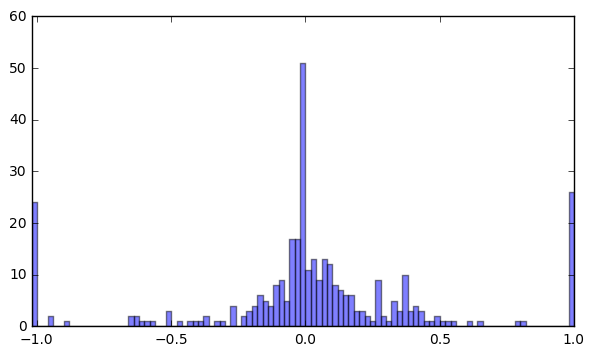

In [77]:
plot_histogram(counts, width)

Certainly looks like a histogram alright. A quick comparison with the pandas function confirms it:

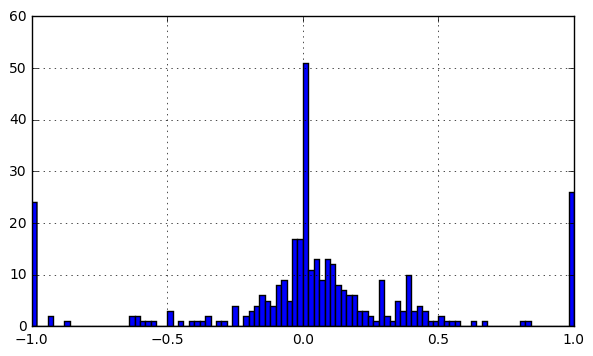

In [35]:
data.loc[:, '3'].hist(figsize=(7, 4), bins=100)

Seems correct.

The histograms above show that, for that particular feature, there appears to be a concentration of sample values around -1, 0, and 1. Let's find out if there is a relationship between any of these three peaks and whether or not the target variable of the samples in question was 'good' or 'bad'. For that, I will write another function that plots two histogram on top of each other, coloring them according to their target variable values.

In [83]:
def plot_histograms_by_target(**kwargs):
    data_pairs_pos = sorted([(bin[0], count) for bin, count in
                            kwargs['positive'][0].items()])
    data_pairs_neg = sorted([(bin[0], count) for bin, count in
                            kwargs['negative'][0].items()])
    x_pos, y_pos = zip(*data_pairs_pos)
    x_neg, y_neg = zip(*data_pairs_neg)
    plt.figure(figsize=(7, 4))
    plt.bar(left=x_pos, height=y_pos, width=kwargs['positive'][1],
            alpha=.5, color='blue')
    plt.bar(left=x_neg, height=y_neg, width=kwargs['negative'][1],
            alpha=.5, color='orange')
    plt.xlim(kwargs['min_val'] - kwargs['positive'][1], 
             kwargs['max_val'])
    plt.show()
    plt.close('all')

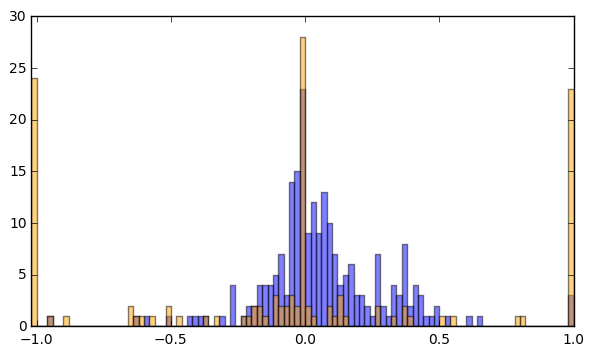

In [84]:
g_series = data.loc[data['target'] == 'g', '3']
b_series = data.loc[data['target'] == 'b', '3']
min_val = min(min(g_series), min(b_series))
max_val = max(max(g_series), max(b_series))
plot_histograms_by_target(
    positive=binned_histogram(g_series, 100, min_val, max_val),
    negative=binned_histogram(b_series, 100, min_val, max_val),
    min_val=min_val, max_val=max_val
)

Interestingly, the overlay of the two histograms according to their target value indicates that the two concentrations around -1 and 1, in the majority of cases, correspond to 'bad' readings whereas the concentration around 0 appears to be almost equally distributed among 'good' and 'bad' target values. 

This type of analysis could now be used for the rest of the variables in order to identify other variables that could turn out to be good predictors (possibly after some transformations) of the target variable. Given the number of features, however, I will omit this here. Instead, I will explore the data a bit further using principal components analysis (PCA).

To calculate a PCA, I will need the covariance matrix of the features:

In [88]:
X = data.as_matrix()[:, :-1]
X_centred = X - np.mean(X, axis=0)

In [106]:
cov_mat = (X_centred.T).dot(X_centred) / (X_centred.shape[0]-1)

The principal components are nothing else but the eigenvectors of the covariance matrix:

In [112]:
cov_mat = cov_mat.astype(np.float64)
princomps = np.linalg.eig(cov_mat)

In [113]:
print(princomps)

(array([ 2.90436153,  1.13708673,  0.69266341,  0.64279583,  0.45167303,
         0.34064532,  0.27816012,  0.26632153,  0.25042157,  0.20886699,
         0.19117632,  0.17037042,  0.16147008,  0.15246957,  0.02134866,
         0.13388771,  0.12946504,  0.03121104,  0.0377422 ,  0.03978231,
         0.04506265,  0.04815018,  0.05340651,  0.05760683,  0.06454805,
         0.06699981,  0.07225005,  0.1188362 ,  0.0880885 ,  0.09342543,
         0.10980726,  0.10096348,  0.10494425]),
 array([[-0.02325839, -0.00635553,  0.08183259, ..., -0.02209133,
         -0.05125669, -0.03927536],
        [-0.10138455, -0.07767383,  0.30494054, ..., -0.26768934,
          0.3191141 ,  0.07597261],
        [ 0.07201262, -0.04604199,  0.14870004, ..., -0.01811717,
         -0.14071322, -0.24593471],
        ..., 
        [-0.02009187, -0.173524  ,  0.13899732, ...,  0.03810156,
          0.032129  ,  0.05001005],
        [-0.20017617,  0.14413142,  0.21658876, ..., -0.10611353,
         -0.18583495, -0.

The first array are the eigenvalues, the second array are the corresponding eigenvectors. Interpretation-wise, the magnitude of the eigenvalues as a fraction of the sum of all eigenvalues gives the overall variance along the axis of the corresponding eigenvector.

Let's compare with the PCA implementation from scikit-learn:

In [114]:
pca = PCA()
pca.fit(X_centred)

PCA(copy=True, n_components=None, whiten=False)

In [116]:
print(pca.components_.T)

[[-0.02325839 -0.00635553  0.08183259 ...,  0.57718291 -0.33591403
   0.21739276]
 [-0.10138455 -0.07767383  0.30494054 ..., -0.13978823 -0.01663054
  -0.16641603]
 [ 0.07201262 -0.04604199  0.14870004 ..., -0.02875172  0.05510034
  -0.14428516]
 ..., 
 [-0.02009187 -0.173524    0.13899732 ...,  0.02912933  0.07656747
   0.15213392]
 [-0.20017617  0.14413142  0.21658876 ...,  0.30603865  0.25578736
  -0.15173189]
 [ 0.01747586 -0.14498102  0.18385181 ...,  0.07506407  0.07102973
  -0.22516923]]


Looking good; any discrepancies are very likely due to slight differences in the numerical algorithms used. For convenience, I'll use the scikit-learn class from now on.

To take a first look at the results of the PCA, let's put together a function for a scree plot:

In [117]:
def scree_plot(explained_var):
    plt.figure(figsize=(7, 4))
    plt.bar(left=range(len(explained_var)), height=explained_var)
    plt.title('scree plot')
    plt.xlabel('principal components')
    plt.ylabel('% variance explained')
    plt.show()
    plt.close('all')

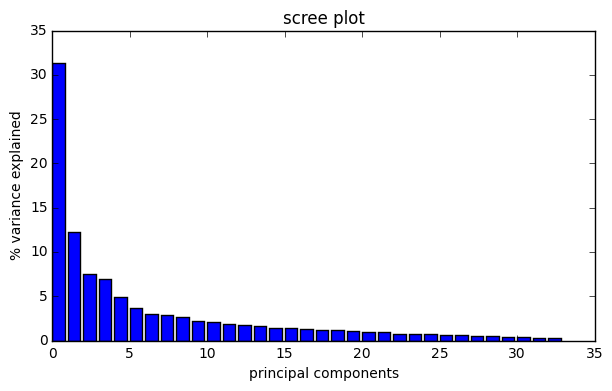

In [118]:
scree_plot(pca.explained_variance_ratio_ * 100)

This is a fairly typical result from a PCA; as can be seen from the plot, more than 30% of the total variance in the dataset is already captured by the first component, with the second PC still explaining about 12-13%. Afterwards, the variance explained per component drops off significantly. Assuming that in particular the later components mostly represent noise, one could use this insight when trying to predict 'good' and 'bad' target values by only using a subset of the components as features. I will explore how this impacts the prediction performance metrics in the prediction.ipynb notebook in this repository.